In [300]:
%pip install tensorflow
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install pydot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense


[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [301]:
from pathlib import Path
import imghdr
import os

data_dir = "hair_types"
image_extensions = [".png", ".jpg"]  # add there all your images file extensions

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [302]:
image_size = (64, 64)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    labels='inferred',
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "hair_types",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size, 
    labels='inferred',
    label_mode='categorical'
)

Found 981 files belonging to 3 classes.
Using 785 files for training.
Found 981 files belonging to 3 classes.
Using 196 files for validation.


In [303]:
class_names = train_ds.class_names
print(class_names)

['Curly_Hair', 'Straight_Hair', 'Wavy_Hair']


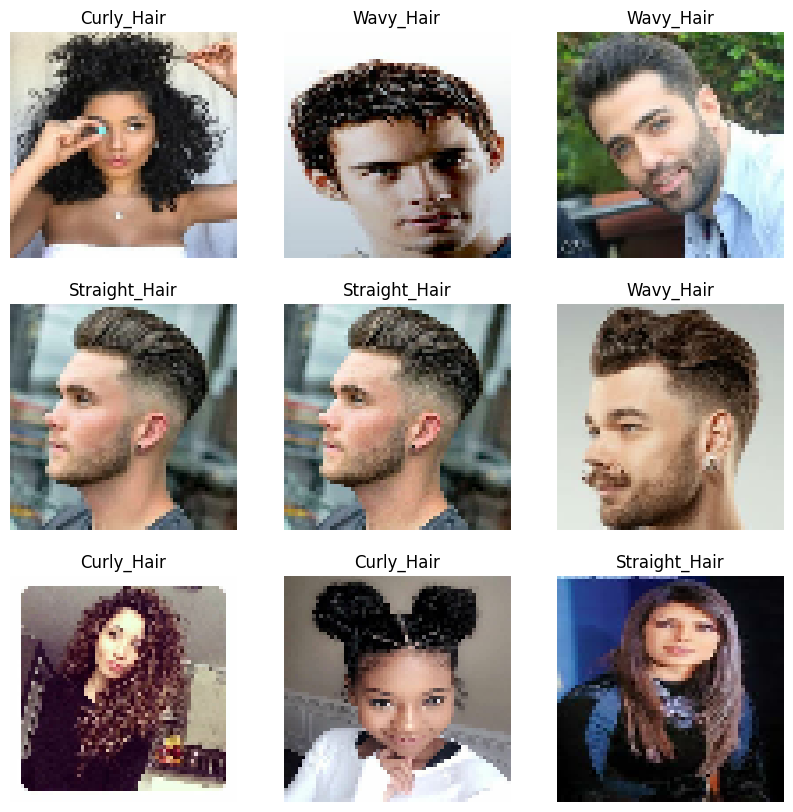

In [304]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(np.argmax(labels[i]))])
        plt.axis("off")
plt.show()

In [305]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [306]:
normalization_layer = layers.Rescaling(1./255)

In [307]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.02647059 0.96470594


In [308]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])
train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

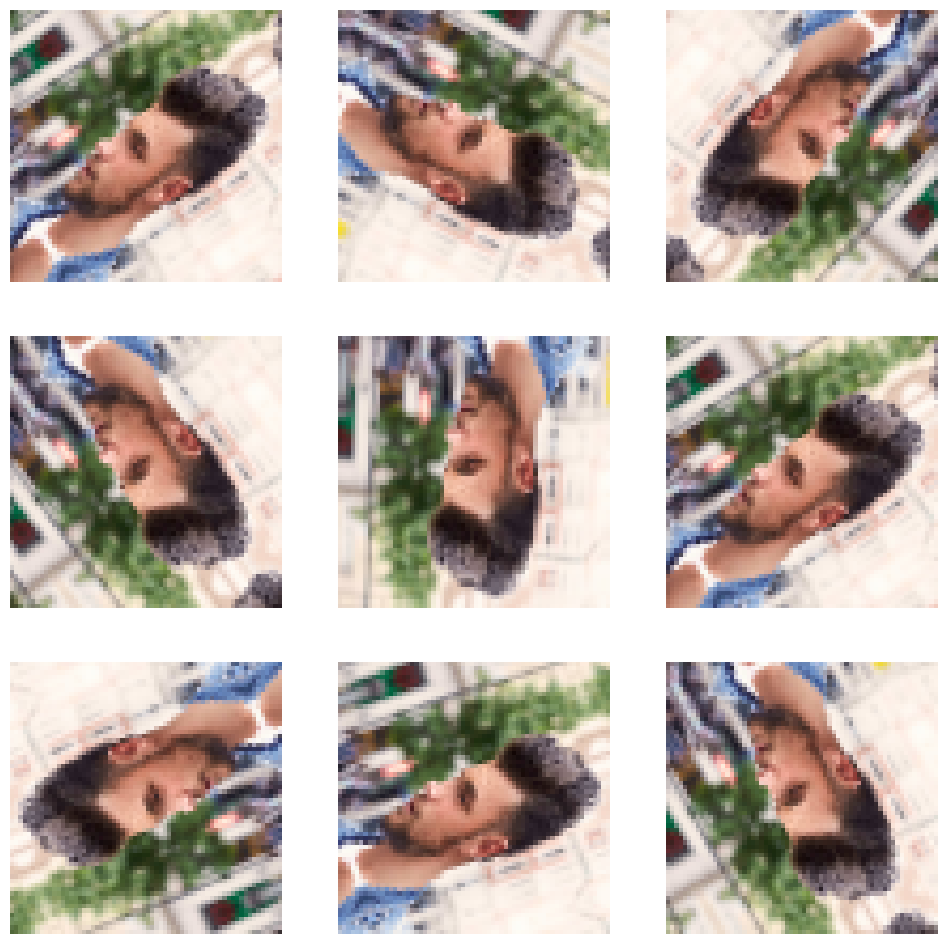

In [309]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [322]:
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(layers.InputLayer(input_shape=image_size + (3,)))  # 64, 64, 3
model.add(layers.experimental.preprocessing.Rescaling(1./255))  # Normalization

model.add(layers.Conv2D(filters=32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(layers.Dense(3, activation='softmax'))


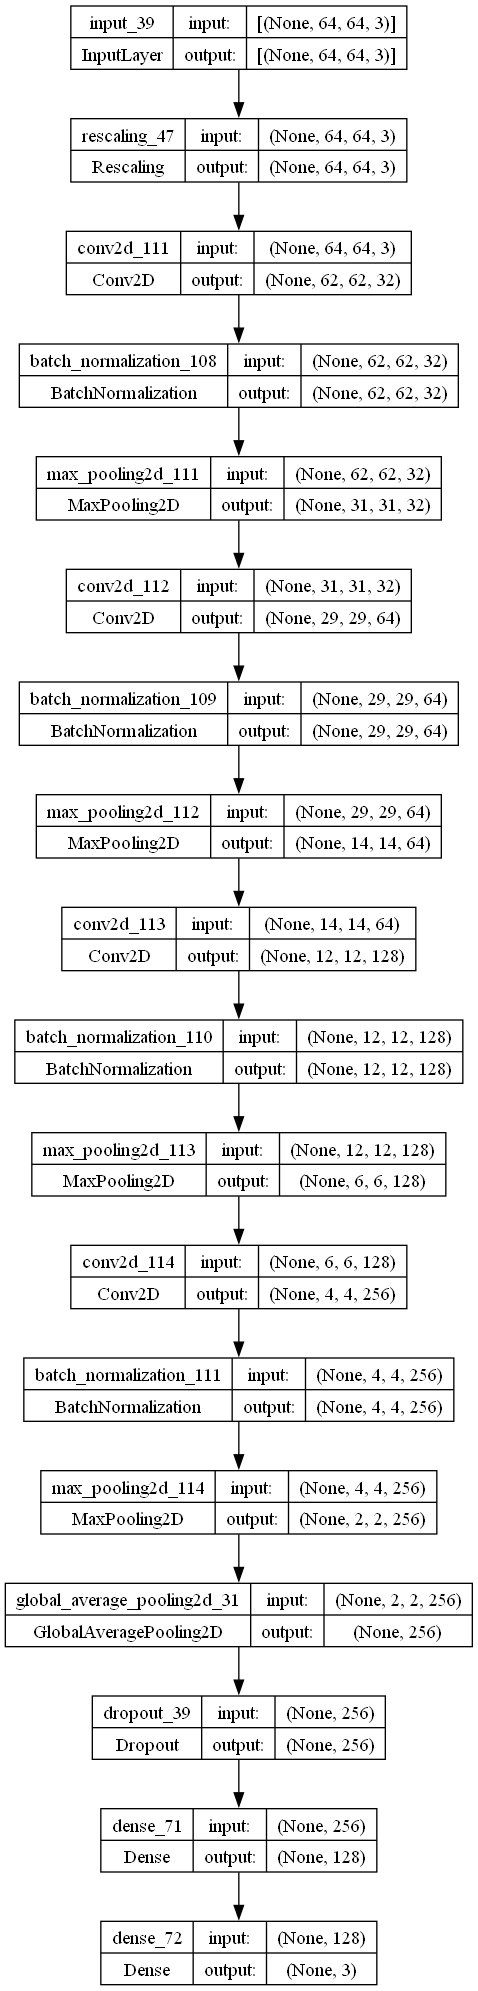

In [323]:
tf.keras.utils.plot_model(model, to_file='model_test.png', show_shapes=True)

In [324]:
model.summary()

Model: "sequential_51"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_47 (Rescaling)    (None, 64, 64, 3)         0         
                                                                 
 conv2d_111 (Conv2D)         (None, 62, 62, 32)        896       
                                                                 
 batch_normalization_108 (B  (None, 62, 62, 32)        128       
 atchNormalization)                                              
                                                                 
 max_pooling2d_111 (MaxPool  (None, 31, 31, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_112 (Conv2D)         (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_109 (B  (None, 29, 29, 64)      

In [325]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

epochs = 50
history = model.fit(train_ds_augmented, epochs=epochs, validation_data=val_ds)

Epoch 1/50
25/25 [==============================] - 4s 117ms/step - loss: 1.9214 - accuracy: 0.4255 - val_loss: 1.5734 - val_accuracy: 0.3265
Epoch 2/50
25/25 [==============================] - 3s 110ms/step - loss: 1.6725 - accuracy: 0.4930 - val_loss: 1.5730 - val_accuracy: 0.3571
Epoch 3/50
25/25 [==============================] - 3s 111ms/step - loss: 1.6661 - accuracy: 0.4790 - val_loss: 1.5698 - val_accuracy: 0.3571
Epoch 4/50
25/25 [==============================] - 3s 108ms/step - loss: 1.6580 - accuracy: 0.4701 - val_loss: 1.5659 - val_accuracy: 0.3418
Epoch 5/50
25/25 [==============================] - 3s 106ms/step - loss: 1.5817 - accuracy: 0.5108 - val_loss: 1.5546 - val_accuracy: 0.4031
Epoch 6/50
25/25 [==============================] - 3s 116ms/step - loss: 1.5887 - accuracy: 0.5045 - val_loss: 1.5654 - val_accuracy: 0.3673
Epoch 7/50
25/25 [==============================] - 3s 118ms/step - loss: 1.5542 - accuracy: 0.5490 - val_loss: 1.6241 - val_accuracy: 0.3673
Epoch 

In [326]:
img = keras.preprocessing.image.load_img(
    "hair_types/Curly_Hair/02dac897d1dec9ba8c057a11d041ada8--layered-natural-hair-natural-black-hairstyles.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = model.predict(img_array)
print(
    "This image is %.2f percent curly hair, %.2f percent straight hair, and %.2f percent wavyhair."
% tuple(predictions[0])
)



1/1 [==============================] - 0s 96ms/step
This image is 1.00 percent curly hair, 0.00 percent straight hair, and 0.00 percent wavyhair.


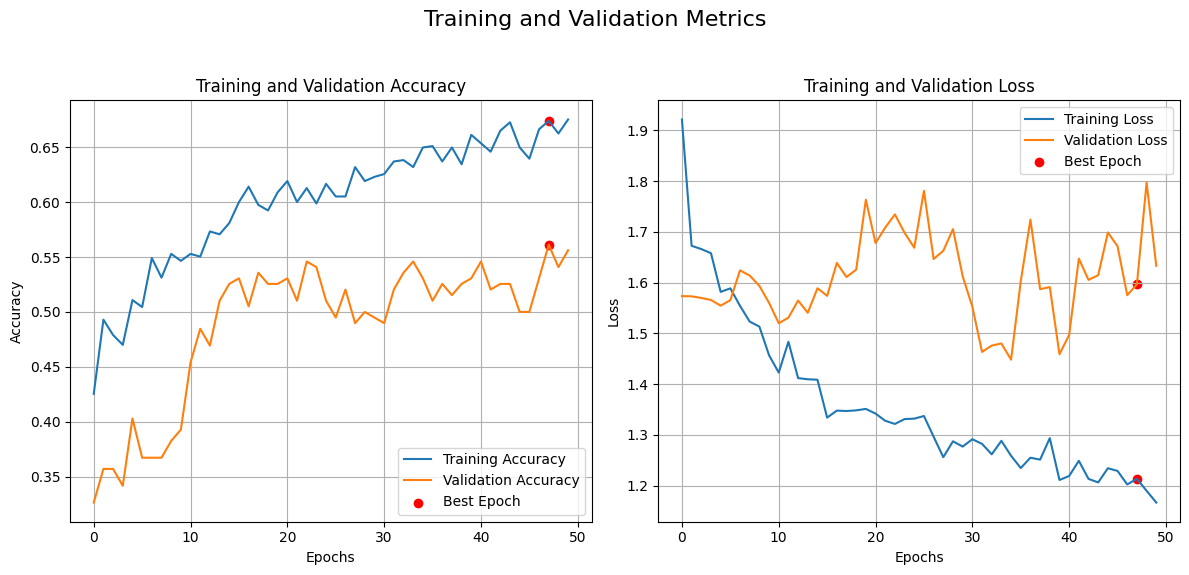

In [327]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

best_epoch = np.argmax(val_acc)

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.scatter(best_epoch, acc[best_epoch], color="red")
plt.scatter(best_epoch, val_acc[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.grid(True)

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.scatter(best_epoch, loss[best_epoch], color="red")
plt.scatter(best_epoch, val_loss[best_epoch], color="red", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.grid(True)

plt.suptitle("Training and Validation Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [328]:
print(f"Best Epoch: {best_epoch + 1}")
print(f"Accuracy at Best Epoch: {acc[best_epoch]:.4f}")
print(f"Validation Accuracy at Best Epoch: {val_acc[best_epoch]:.4f}")
print(f"Loss at Best Epoch: {loss[best_epoch]:.4f}")
print(f"Validation Loss at Best Epoch: {val_loss[best_epoch]:.4f}")

Best Epoch: 48
Accuracy at Best Epoch: 0.6739
Validation Accuracy at Best Epoch: 0.5612
Loss at Best Epoch: 1.2135
Validation Loss at Best Epoch: 1.5968
